<a href="https://colab.research.google.com/github/skmisht/CNN/blob/main/CNN_Keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Melanoma detection using - Keras

#Mount Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


#Data Preparation

```
1.   Training Data
2.   Validation Data
3.   Training Data

```



In [2]:
import pandas as pd 

training_truth_data = pd.read_csv('/content/drive/MyDrive/isic-challenge-2017/ISIC-2017_Training_Part3_GroundTruth.csv') 
testing_truth_data = pd.read_csv('/content/drive/MyDrive/isic-challenge-2017/ISIC-2017_Test_v2_Part3_GroundTruth.csv') 
validation_truth_data = pd.read_csv('/content/drive/MyDrive/isic-challenge-2017/ISIC-2017_Validation_Part3_GroundTruth.csv')

training_metadata = pd.read_csv('/content/drive/MyDrive/isic-challenge-2017/ISIC-2017_Training_Data/ISIC-2017_Training_Data/ISIC-2017_Training_Data_metadata.csv')
testing_metadata = pd.read_csv('/content/drive/MyDrive/isic-challenge-2017/ISIC-2017_Test_v2_Data/ISIC-2017_Test_v2_Data/ISIC-2017_Test_v2_Data_metadata.csv')
validation_metadata = pd.read_csv('/content/drive/MyDrive/isic-challenge-2017/ISIC-2017_Validation_Data/ISIC-2017_Validation_Data/ISIC-2017_Validation_Data_metadata.csv')

path_training_images ='/content/drive/MyDrive/isic-challenge-2017/ISIC-2017_Training_Data/ISIC-2017_Training_Data/'
path_testing_images ='/content/drive/MyDrive/isic-challenge-2017/ISIC-2017_Test_v2_Data/ISIC-2017_Test_v2_Data/'
path_validation_images = '/content/drive/MyDrive/isic-challenge-2017/ISIC-2017_Validation_Data/ISIC-2017_Validation_Data/'


#add new column to truth_data witht he path to corresponding image
def prepare_data(truth_data, metadata, image_path):
  path_to_images_array = []
  for x in truth_data.values:
    path_to_image = image_path+str(x[0])+'.jpg'
    path_to_images_array.append(str(path_to_image))
  #add path to image to the truth data frame
  truth_data['path_to_image'] = path_to_images_array
  #return merge truth data with metadata, join on the image_id's
  return pd.merge(truth_data, metadata, left_on='image_id', right_on='image_id', how='left')


training_data = prepare_data(training_truth_data, training_metadata, path_training_images)
testing_data = prepare_data(testing_truth_data, testing_metadata, path_testing_images)
validation_data = prepare_data(validation_truth_data, validation_metadata, path_validation_images)

pd.set_option("display.max_rows", None, "display.max_columns", None)
pd.set_option('display.max_colwidth', None)
print(training_data.head())


       image_id  melanoma  seborrheic_keratosis  \
0  ISIC_0000000       0.0                   0.0   
1  ISIC_0000001       0.0                   0.0   
2  ISIC_0000002       1.0                   0.0   
3  ISIC_0000003       0.0                   0.0   
4  ISIC_0000004       1.0                   0.0   

                                                                                                 path_to_image  \
0  /content/drive/MyDrive/isic-challenge-2017/ISIC-2017_Training_Data/ISIC-2017_Training_Data/ISIC_0000000.jpg   
1  /content/drive/MyDrive/isic-challenge-2017/ISIC-2017_Training_Data/ISIC-2017_Training_Data/ISIC_0000001.jpg   
2  /content/drive/MyDrive/isic-challenge-2017/ISIC-2017_Training_Data/ISIC-2017_Training_Data/ISIC_0000002.jpg   
3  /content/drive/MyDrive/isic-challenge-2017/ISIC-2017_Training_Data/ISIC-2017_Training_Data/ISIC_0000003.jpg   
4  /content/drive/MyDrive/isic-challenge-2017/ISIC-2017_Training_Data/ISIC-2017_Training_Data/ISIC_0000004.jpg   

  age_ap

#Peek at images from training data

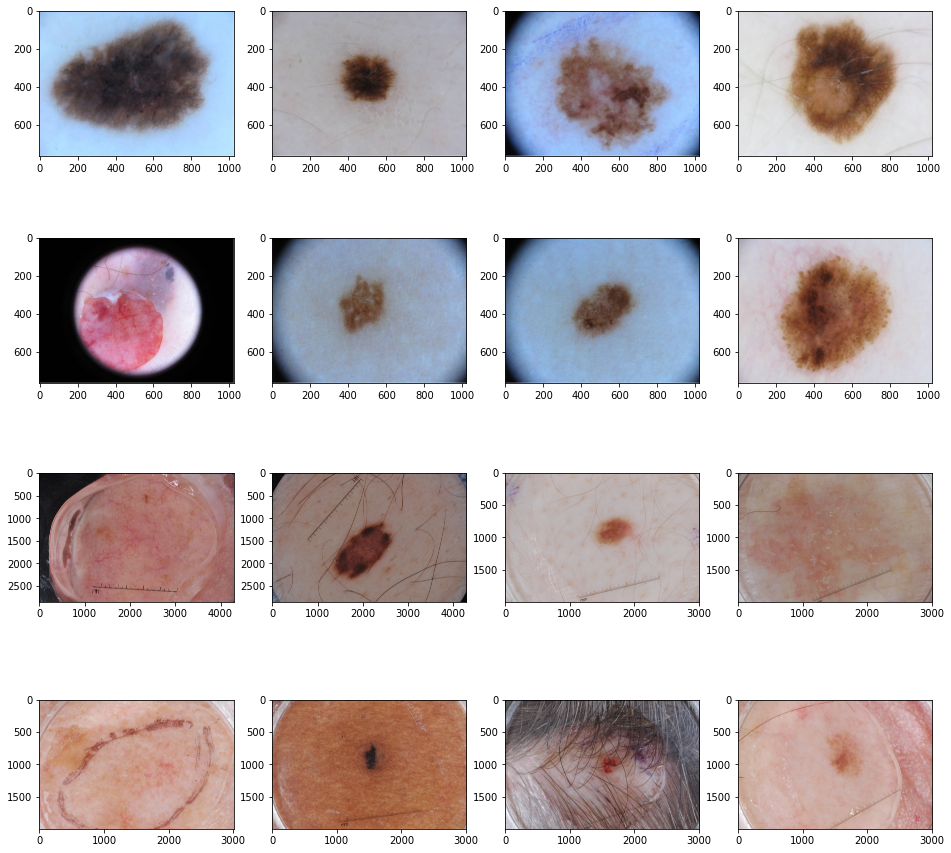

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
nrows, ncols = 4, 4
pic_index=0

# Display a batch of 8 training and 8 test images, also we can rerun the cell to see a fresh batch at each time
# set up matplotlib fig, and size to fit our 4*4 images
fig = plt.gcf()
fig.set_size_inches(ncols*4, nrows*4)

# increment the pic_index upto 8
pic_index += 8

# listing images from training and and test data
training_list_of_images = training_data['path_to_image'].to_list()
test_list_of_images = testing_data['path_to_image'].to_list()

# iterate over the training and test images
train_melanoma_image = [name for name in training_list_of_images[pic_index-8:pic_index]]
test_melanoma_image = [name for name in test_list_of_images[pic_index-8:pic_index]]

# enumerting over the train and test images
for i, image_path in enumerate(train_melanoma_image + test_melanoma_image):
  # set up the subplot - subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  # do not display axis or gridline
  img = mpimg.imread(image_path)
  plt.imshow(img)

# display images
plt.show()


#Image/Label Data Preparation

In [3]:
from PIL import Image
import numpy as np

# load the image
def get_data(data, type_data):
  print(f'preparing {type_data}')
  print('Loading images to memory')
  #load Image data, resize to 256 by 256 pixel and load into numpy array
  image_data = np.array([np.array(Image.open(x[3]).resize((256,256))) for x in data.values])
  print('Images Loaded')
  print('Loading Labels')
  #load labels into numpy array
  image_label = np.array([np.array(x[1]) for x in data.values])
  print('Loading Labels Finished')
  return image_data, image_label


#Generate Training Data
Separated generation of test, train, validate data to reduce RAM usage 

In [4]:
import numpy as np
import keras
# Model / data parameters
num_classes = 2
input_shape = (256, 256, 3)

# get training data
x_train, y_train = get_data(training_data,'Training Data')

# Scale images to the [-1, 1] range
x_train = x_train.astype("float32") / 127.5 - 1

print(x_train.shape[0], "train samples")
print(x_train.shape)
print(y_train.shape)
# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)


preparing Training Data
Loading images to memory
Images Loaded
Loading Labels
Loading Labels Finished
2000 train samples
(2000, 256, 256, 3)
(2000,)


#Test post transformation. show image from np array


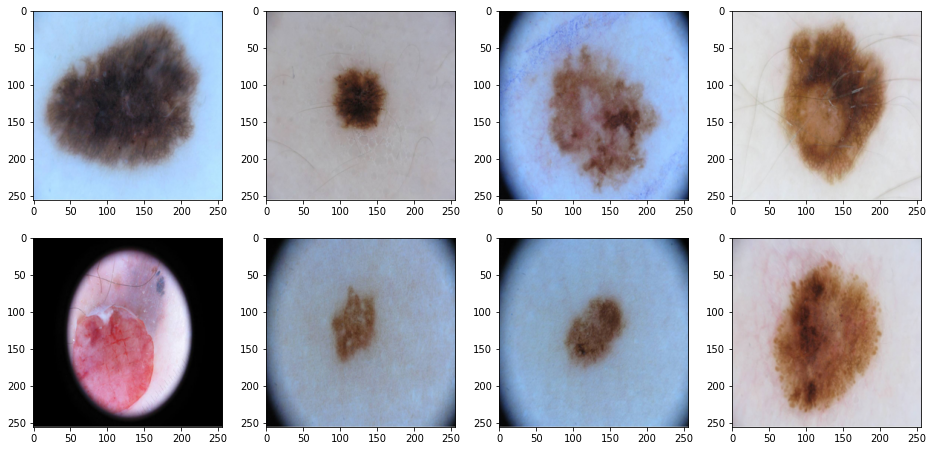

In [ ]:
from PIL import Image
from numpy import asarray

from matplotlib import image

nrows, ncols = 4, 4
fig = plt.gcf()
fig.set_size_inches(ncols*4, nrows*4)

counter = 0
for data in x_train[:8]:
  sp = plt.subplot(nrows, ncols, counter + 1)
  data = (data.astype("float32") + 1) * 127.5
  data = data.astype(np.uint8)
  image = Image.fromarray(data)
  plt.imshow(image)
  counter = counter+1
plt.show()

#Define CNN architecture

```
First Iteration One Convolutional Layer
  model = keras.Sequential(
      [
          keras.Input(shape=input_shape),
          layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
          layers.MaxPooling2D(pool_size=(2, 2)),
          layers.Flatten(),
          layers.Dropout(0.5),
          layers.Dense(2, activation='sigmoid')
      ]
  )
```

In [5]:
from keras.layers import Conv2D, MaxPooling2D
from keras import layers
import keras
input_shape = (256, 256, 3)
#Define CNN architecture
model = keras.Sequential(
    [
        layers.Conv2D(32, (3, 3), activation='relu', padding="same", input_shape=input_shape, data_format='channels_last'),
        layers.Conv2D(32, (3, 3), activation='relu'),
        layers.MaxPooling2D(pool_size=(2,2)),
        layers.Dropout(0.2),
        layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D(pool_size=(2,2)),
        layers.Dropout(0.2),
        layers.Flatten(),
        layers.Dense(512,activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(2,activation='sigmoid')
    ]
)
layers

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 256, 256, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 254, 254, 32)      9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 127, 127, 32)      0         
_________________________________________________________________
dropout (Dropout)            (None, 127, 127, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 127, 127, 64)      18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 125, 125, 64)      36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 62, 62, 64)        0

#Train The Model

```
First iteration
    batch_size = 128
    epochs = 10
    Results:
    Epoch 1/10
    15/15 [==============================] - 72s 5s/step - loss: 2.9174 - accuracy: 0.7328 - val_loss: 1.0437 - val_accuracy: 0.7800
    Epoch 2/10
    15/15 [==============================] - 65s 4s/step - loss: 0.7646 - accuracy: 0.7069 - val_loss: 1.1535 - val_accuracy: 0.5700
    Epoch 3/10
    15/15 [==============================] - 65s 4s/step - loss: 0.5507 - accuracy: 0.7767 - val_loss: 0.7230 - val_accuracy: 0.8100
    Epoch 4/10
    15/15 [==============================] - 65s 4s/step - loss: 0.4865 - accuracy: 0.8151 - val_loss: 0.6484 - val_accuracy: 0.7400
    Epoch 5/10
    15/15 [==============================] - 65s 4s/step - loss: 0.3791 - accuracy: 0.8384 - val_loss: 0.6094 - val_accuracy: 0.7800
    Epoch 6/10
    15/15 [==============================] - 65s 4s/step - loss: 0.3599 - accuracy: 0.8337 - val_loss: 0.6483 - val_accuracy: 0.7000
    Epoch 7/10
    15/15 [==============================] - 65s 4s/step - loss: 0.3413 - accuracy: 0.8769 - val_loss: 0.6049 - val_accuracy: 0.8100
    Epoch 8/10
    15/15 [==============================] - 65s 4s/step - loss: 0.3442 - accuracy: 0.8502 - val_loss: 0.6112 - val_accuracy: 0.7900
    Epoch 9/10
    15/15 [==============================] - 65s 4s/step - loss: 0.3025 - accuracy: 0.8780 - val_loss: 0.8383 - val_accuracy: 0.6700
    Epoch 10/10
    15/15 [==============================] - 72s 5s/step - loss: 0.3030 - accuracy: 0.8769 - val_loss: 0.7285 - val_accuracy: 0.7150
```



In [ ]:
batch_size = 128
epochs = 10

model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy","AUC"])

model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1, shuffle=True)

model.save_weights('/content/drive/MyDrive/Saved Weights/model.h5')


Epoch 1/10
15/15 [==============================] - 579s 37s/step - loss: 1.4856 - accuracy: 0.6982 - auc: 0.7682 - val_loss: 0.5236 - val_accuracy: 0.8350 - val_auc: 0.8401
Epoch 2/10
15/15 [==============================] - 550s 37s/step - loss: 0.5168 - accuracy: 0.8151 - auc: 0.8200 - val_loss: 0.4716 - val_accuracy: 0.8350 - val_auc: 0.8585
Epoch 3/10
15/15 [==============================] - 591s 40s/step - loss: 0.4640 - accuracy: 0.8266 - auc: 0.8509 - val_loss: 0.4719 - val_accuracy: 0.8350 - val_auc: 0.8601
Epoch 4/10
15/15 [==============================] - 604s 40s/step - loss: 0.4672 - accuracy: 0.8109 - auc: 0.8517 - val_loss: 0.4708 - val_accuracy: 0.8300 - val_auc: 0.8502
Epoch 5/10
 4/15 [=======>......................] - ETA: 6:56 - loss: 0.5045 - accuracy: 0.7817 - auc: 0.8304

#Evaluate The Model Performance

```
First Iteration
  Test loss: 0.6319829821586609
  Test accuracy: 0.753333330154419
```



In [1]:
x_validate, y_validate =get_data(validation_data, 'Testing Data')
x_validate = x_validate.astype("float32") / 127.5 - 1
y_validate = keras.utils.to_categorical(y_validate, num_classes)

score = model.evaluate(x_validate, y_validate, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

NameError: ignored

#Prediction and Confusion Matrix (Test)

In [ ]:
import tensorflow as tf

for x in testing_data.head(20).values:
  img = keras.preprocessing.image.load_img(
      x[3], target_size=(256,256)
  )
  img_array = keras.preprocessing.image.img_to_array(img)
  img_array = img_array.astype("float32") / 127.5 - 1
  img_array = tf.expand_dims(img_array, 0)  # Create batch axis
  predictions = model.predict(img_array)
  score = predictions[0]
  print(predictions)
  print(
      "%s This image is %.2f percent malignant and %.2f percent benign."
      % (x[0], 100 * (1 - score[0]), 100 * score[1])
  )

[[0.16152298 0.87988365]]
ISIC_0012086 This image is 83.85 percent malignant and 87.99 percent benign.
[[0.97079605 0.03807449]]
ISIC_0012092 This image is 2.92 percent malignant and 3.81 percent benign.
[[0.98178226 0.02119675]]
ISIC_0012095 This image is 1.82 percent malignant and 2.12 percent benign.
[[0.7256267  0.28050297]]
ISIC_0012134 This image is 27.44 percent malignant and 28.05 percent benign.
[[0.8935182  0.12283656]]
ISIC_0012136 This image is 10.65 percent malignant and 12.28 percent benign.
[[0.9950567  0.00505495]]
ISIC_0012147 This image is 0.49 percent malignant and 0.51 percent benign.
[[0.98758817 0.01800632]]
ISIC_0012149 This image is 1.24 percent malignant and 1.80 percent benign.
[[0.9608406  0.04160884]]
ISIC_0012152 This image is 3.92 percent malignant and 4.16 percent benign.
[[0.9212016  0.08815157]]
ISIC_0012178 This image is 7.88 percent malignant and 8.82 percent benign.
[[0.91708744 0.08428124]]
ISIC_0012199 This image is 8.29 percent malignant and 8.43 